
# Respuesta Examen Primer Parcial Aprendizaje Automático Noviembre 2021

* Construiremos un modelo que pr**edice la eficiencia de combustible de vehículos** entre 1970 y 1980 a partir de del conjunto de datos Auto MPG124.

* **PASO 1**: **Definir el problema** y plantearse si tenemos los datos adecuados para atacarlo ¿Qué intentamos predecir? **MPG de una serie de coches (valor continuo)** ¿Cuáles serán los datos de entrada?:
  - **Millas por galón** (Miles per Gallon) (mpg):variable continua 
  - **Cilindros** (cylinders) : variable discreta de valores múltiples
  - **Desplazamiento** (displacement) : variable continua
  - **Potencia** (horsepower) : variable continua
  - **Peso** (weight) : variable continua
  - **Aceleración** (acceleration) : variable continua
  - **Año del modelo** (model year) : variable discreta de valores múltiples
  - **Origen** (origin) : variable categórica 
* ¿Qué tipo de problema estamos intentando solucionar? Es claramente una **REGRESIÓN**
  - Consideraremos como entrada al modelo los datos **cylinders**, **displacement**, **horsepower**, **weight**, **acceleration**, **model year** y **origin**. 
- Consideramos como salida: **Miles per Gallon** (mpg). 

Estamos ante una **hipótesis de trabajo que parece bastante plausible**, es decir, con esta información de un coche podremos estimar cuál será su consumo. Es una típica tarea de regresión

### Inicialización

Primero importamos todos los paquetes Python 
que se usarán en el código o pseudocódigo de este examen

In [44]:
%tensorflow_version 2.x
import tensorflow as tf

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


2.7.0


### Descarga datos Auto MPG

Descargamos el dataset Auto MPG. En este ejercício toda la información se encuentra en un único fichero llamado `auto-mpg.data`. En el examen, obviamente, esto no era necesario. Damos por hecho que lo tenemos cargado ya en las variables correspondientes

In [45]:
dataset_path = tf.keras.utils.get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

* El siguiente paso es importar los datos usando la librería **Pandas** para manipulación y análisis de datos. 
* Pandas ofrece estructuras de datos y operaciones para manipular tablas numéricas. Especialmente útil la clase `DataFrame`

In [46]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',   'Acceleration', 'Model Year', 'Origin'] 

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()

* Una práctica interesante es echarle un vistazo rápido a la estructura de datos. 
* Podemos visualizar las cinco últimas filas con el método `tail()` que nos ofrece Pandas

In [47]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [48]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


* Podemos ver que los valores de las diferentes columnas son los esperados y podemos comprobar que disponemos de **398 muestras** (de la 0 a la 397). 

**TRATAMIENTO DE VALORES VACÍOS**
* También es interesante comprobar en esta etapa **si falta algún valor** para garantizar que nuestros datos son correctos. Para ello, podemos usar el método `insa()` que nos ofrece Pandas para detectar si faltan elementos. 
* **Qué hacer con los datos perdidos**: Es muy habitual, en los problemas del mundo real, que falten algunos valores de los datos de muestra. Esto puede ser debido a errores de recopilación de datos, a errores de transformación de datos, etc. Los campos vacíos se representan típicamente con los indicadores ``NaN`` o ``Null``. **El problema es que en redes neuronales no podemos dejar estos valores faltantes**, por lo que **los tenemos que 
tratar antes de alimentar nuestro modelo con datos**. 
* En el examen, ya os decía que había valores que faltaban y quería que me dijerais que vais a hacer con ellos. A priori, cualquier respuesta bien argumentada era válida: 
  - **Borrarlos**: eliminando las características (columnas) o muestras (filas) con campos vacíos, destacando que no sería la mejor opción porque hay muy pocos valores en el DataSet
  - **Mantenerlo con valor 0**, ya que no es un valor representativo en los datos (no existen coches con 0 caballos de vapor, con lo que el sistema aprendería que son valores nulos)
  - Meterle la **media de los valores de los CV del resto de datos** con valor. La librería `ScikitLearn` nos ayuda a estimar los campos vacíos con algún estimador

In [49]:
print(dataset.isna().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


* Para mantener este ejemplo simple, optamos por la primera opción y, simplemente, borramos las filas usando el método ``dropna()`` que nos proporciona Pandas.
* Este es un paso delicado en los casos reales y requiere una decisión más pensada, puesto que simplemente eliminando corremos el riesgo de borrar información relevante —podemos estar borrando demasiadas muestras, o incluso podemos estar modificando la distribución de los datos de entrada—.

In [50]:
dataset = dataset.dropna()

**MANEJO DE DATOS CATEGÓRICOS** 
* La columna de datos ``Origin`` no es numérica, sino categórica, es decir, el 1 significa «USA», el 2 «Europa» y el 3 «Japan». Cuando sucede esto, se usa habitualmente la técnica de **codificación one-hot**
* Consiste en crear una característica «ficticia» para cada valor único en la columna de características. Asigna a los datos de entrada su propio vector y les da un valor de 1 o 0. 
* Para ello, en nuestro caso de datos, usaremos el método ``pop()`` que proporciona Pandas para extraer de los datos la columna Origin, y la sustituiremos por tres nuevas columnas:

In [51]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0

Podemos volver a echarle un vistazo rápido a la estructura de datos con el método ``tail()``; vemos que se han creado las tres nuevas columnas que sustituyen a la columna ``Origin``:

In [52]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


Esto ya se os da hecho en el Examen

## Separar los datos para entrenar y evaluar

En los ejemplos vistos en clase, los datos ya se encontraban divididos en cuatro arrays NumPy, al igual que se han dado en el examen:
* Datos de entrenamiento (training) y sus etiquetas respectivas: 
  - ``train_data``
  - ``train_labels``
* Datos de prueba (test) y sus etiquetas respectivas:
  - ``test_data``
  - ``test_labels`` 

Aquí os cuento como se han partido para el examen, pero debeis tener en cuenta y hablar sobre ello que para la configuración y evaluación de un modelo en Machine Learning, habitualmente se dividen los datos disponibles en dos conjuntos: 
* Datos de entrenamiento (training)
* Datos de prueba (test). 

A su vez, **una parte de los datos de entrenamiento (training) se reservan como datos de validación(validation)**. 
Los datos de entrenamiento que nos quedan después de sacar los de validación y prueba son los que se usan para que el algoritmo de aprendizaje calcule los parámetros del modelo, mientras que los de **validación se usan para afinar los hiperparámetros**. 

Con las métricas —como con la precisión (**accuracy**)— que se pueden obtener de este conjunto de datos de validación nos guiamos para decidir cómo ajustar los hiperparámetros del algoritmo antes de repetir el proceso de entrena- 
miento. 

Es importante notar en el examen que **cuando nos esforzamos para mejorar el algoritmo ajustando los hiperparámetros gracias al comportamiento del modelo con los datos de validación**, estamos **inadvertidamente incidiendo en el modelo, que 
puede sesgar los resultados a favor del conjunto de validación**. De aquí la importancia de disponer de un conjunto de datos de prueba **reservados para una prueba final**, con **datos que el modelo no ha visto nunca anteriormente** durante la etapa de 
entrenamiento (ni como datos de entrenamiento ni como datos de validación).

Esto permite obtener una medida de comportamiento del algoritmo más objetiva y **evaluar si nuestro modelo generaliza correctamente**. 

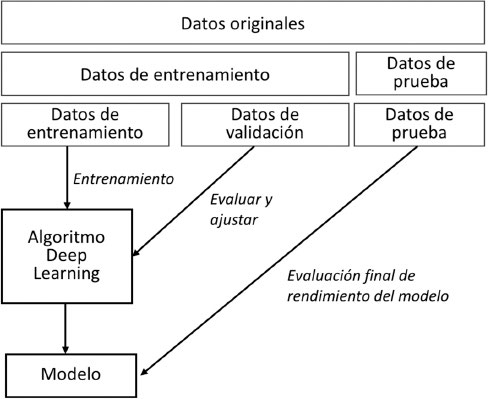



Esta es la estrategia de evaluación más habitual. Pero hay otras e**strategias de repartir los datos para validar** los modelos **cuando tenemos escasez de datos**, como por ejemplo la **validación cruzada** (cross-validation) que, básicamente, **divide los datos en K particiones del mismo tamaño** y para cada partición ``i`` el modelo es entrenado con las restantes ``K-1`` particiones, y evaluado en la propia partición ``i``. 

En nuestro ejemplo podemos repartir los datos mediante el método ``sample()`` que nos proporciona Pandas, indicando con el argumento ``frac`` inicializado a 0.8 que **queremos usar el 80 % de los datos para entrenamiento**, y que los almacenamos en ``train_data``:

In [53]:
train_data = dataset.sample(frac=0.8,random_state=0)
# El resto de datos los almacenamos en test_data:
test_data = dataset.drop(train_data.index)

También debemos **separar la columna de datos que contiene los valores que queremos predecir (MPG)**:

In [54]:
train_labels = train_data.pop('MPG')
test_labels = test_data.pop('MPG')

**NORMALIZAR LOS DATOS DE ENTRADA** 
Como venimos estudiando, es una buena práctica normalizar los datos para ser consumidos por las redes neuronales: 
* Sus valores generalmente deben **escalarse a valores pequeños**, en el rango ``[-1, 1]`` o ``[0, 1]``. 
* Si **diferentes características** de los valores de entrada **presentan valores en diferentes rangos** (datos heterogéneos), es **conveniente normalizar los datos**. 

Podemos inspeccionar los datos de entrada mediante el método ``describe()`` que ofrece el paquete Pandas para ver medianas y desviaciones.

In [55]:
train_stats = train_data.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


* Mirando el resultado podemos observar lo diferente de los rangos de cada característica. **Procede normalizar**. 
* Aunque el modelo **podría converger sin normalización** de características, se ha demostrado que **no hacerlo dificulta el entrenamiento**, y puede hacer que el **modelo resultante dependa de la elección de las unidades** utilizadas en la entrada. 
* Importante **normalizar** de la misma manera el **conjunto de datos de prueba**, así como los **datos que posteriormente use el modelo durante la etapa de inferencia**. 

In [56]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_data)
normed_test_data = norm(test_data)

La función `norm` reescala las características en un rango [0,1] (normalización) y centra las columnas de características con respecto a una media 0 con desviación estándar 1 (estandarización), de forma que las **columnas de características tengan los mismos parámetros que una distribución normal estándar** (media cero y varianza unidad).

Vemos como los datos se han estandarizado adecuadamente:

In [57]:
normed_train_stats = normed_train_data.describe()
normed_train_stats = normed_train_stats.transpose()
normed_train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,2.093159e-16,1.0,-1.457657,-0.869348,-0.869348,1.483887,1.483887
Displacement,314.0,1.018294e-16,1.0,-1.220325,-0.860894,-0.424785,0.675074,2.489002
Horsepower,314.0,-1.909301e-17,1.0,-1.545283,-0.751241,-0.272190,0.607162,3.153347
Weight,314.0,-9.723291e-17,1.0,-1.589352,-0.869478,-0.198782,0.732017,2.547401
Acceleration,314.0,2.688832e-15,1.0,-2.710152,-0.630725,-0.021237,0.588250,3.313017
Model Year,314.0,9.561531e-16,1.0,-1.604642,-0.788458,0.027726,0.843910,1.660094
USA,314.0,6.081476e-17,1.0,-1.286751,-1.286751,0.774676,0.774676,0.774676
Europe,314.0,8.485781e-18,1.0,-0.465148,-0.465148,-0.465148,-0.465148,2.143005
Japan,314.0,3.164489e-17,1.0,-0.495225,-0.495225,-0.495225,-0.495225,2.012852


## Desarrollar el modelo

Ahora tenemos que desarrollar un modelo que cumpla 
con nuestras expectativas.Vamos a decidir por qué tipo de arquitectura nos decantamos, y el valor de los hiperparámetros.

Para establecer las restricciones que requerimos en la salida de la red neuronal, debemos **primero decidir cuál es nuestra última capa**, qué tipo de **activación** usaremos y la **relación con la función de pérdida** que se definirá para el modelo.

En en el caso que nos ocupa, **regresión**, **no meteremos función de activación**. La salida irá en bruto, es decir, con una capa `layers.Dense(1)` es suficiente, puesto que lo que **esperamos de salida es un valor continuo**. 

Para empezar, consideremos una **arquitectura simple** de **dos capas densamente conectadas**, de **64 neuronas**:

In [58]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

def build_model():  
  model = Sequential()
  model.add(Dense(64, activation='relu', input_shape=[len(train_data.keys())]))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1))
  return model

model = build_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 64)                640       
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dense_14 (Dense)            (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


Se ha encapsulado esta definición de modelo en una función para facilitar el poder probar con diferentes hiperparámetros sobre el mismo modelo. 

Podemos inspeccionar la arquitectura de la red con el método ``summary()``: (**El resultado de esto había que ponerlo en el examen**)

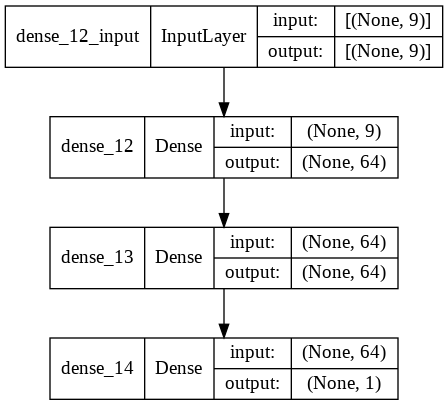

In [59]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='modeloFinal_plot.png', show_shapes=True)

### CONFIGURACIÓN DEL MODELO

Otras de las decisiones clave en la construcción de nuestro modelo son la definición y configuración de la **función de pérdida** y el **optimizador**.

**FUNCIÓN DE PÉRDIDA**  
La función de perdida, **basada en una métrica de rendimiento**, **debe coincidir con el tipo de problema que estamos tratando de resolver**. 

Una **medida de rendimiento típico** para un problema de **regresión** es la **raíz del error cuadrático medio** (root mean square error) (**MSE**), que es la **raíz cuadrada de la suma ponderada del cuadrado de las diferencias entre los valores previstos y los valores observados**:

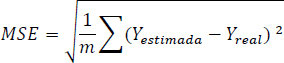

Aunque el **MSE** es generalmente la **medida de rendimiento preferida para tareas de regresión**, en algunos contextos **puede usarse** otra función: el **error absoluto medio** (mean absolute error) (**MAE**), también llamado promedio absoluto de la desviación:

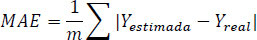

**Ambas métricas son usadas en modelos de regresión**. 
* **MAE** es **más robusto para los valores atípicos**, ya que no utiliza el cuadrado (debido al cuadrado del MSE, los errores grandes tienen una influencia relativamente mayor que los errores 
más pequeños).
* **MSE** es más **útil si nos preocupan los errores grandes** cuyas consecuencias son mucho mayores que los errores equivalentes más pequeños

**OPTIMIZADOR**
para este caso decidimos usar el optimizador ``RMSprop``, que es un buen punto de partida en general, con un ratio de aprendizaje de 0.001:

In [60]:
optimizer = tf.keras.optimizers.RMSprop(0.001)

In [61]:
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

## Entrenamiento del modelo

El valor del hiperparámetro ``epoch`` es importante, puesto que es muy probable que 
**más épocas muestren una mayor precisión** de la red para los **datos de entrenamiento**. Pero, a su vez, también debe tenerse en cuenta que si el **número de épocas es demasiado alto**, la red podría tener **problemas de sobreajuste**
* Encontrar el valor adecuado tendrán un **papel muy importante los datos de validación** que hemos definido anteriormente. 
* Proponemos entrenar con **1000 epochs** (un número suficientemente alto sería válido) para **provocar precisamente que se manifieste este problema de sobreentrenamiento**. 
* Para especificar qué parte de los datos de entrenamiento queremos reservar para 
validación, podemos recurrir al argumento ``validation_split`` del método ``fit()``. 
* Un valor de partida puede ser el 0.2, que representa el **20 %**:

In [62]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0)

Si pusiéramos ``verbose=1`` y miráramos la salida, veríamos con detalle cómo evoluciona el proceso de entrenamiento viendo como nos devolvería las métricas en cada ``epoch`` tanto de los **datos de entrenamiento** (``loss``, ``mae``, ``mse``), como de las métricas obtenidas con los **datos de validación** (``val_loss``,``val_mae``, ``val_mse``)

## Evaluación del modelo

**VISUALIZACIÓN DEL PROCESO DE ENTRENAMIENTO**

Usamos el **objeto historial** que el método ``fit()`` que devuelve estadísticas que nos interesa

In [63]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.321847,0.972361,2.321847,9.928743,2.411980,9.928743,995
996,2.324000,0.931339,2.324000,10.046384,2.399389,10.046384,996
997,2.330236,0.947778,2.330236,9.928212,2.424668,9.928212,997
998,2.383396,0.962325,2.383396,10.191072,2.455176,10.191072,998
999,2.313720,0.961234,2.313720,9.929993,2.404375,9.929993,999


Para ver gráficamente **cómo evolucionan estos valores** durante el entrenamiento podemos recurrir al siguiente código:

In [64]:
def plot_history(history):     
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error')
  plt.plot(hist['epoch'], hist['mse'],'r--',
           label='Training Error')
  plt.plot(hist['epoch'], hist['val_mse'],'b',
           label = 'Validation Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()

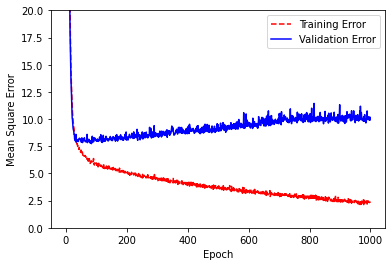

In [65]:
plot_history(history)

La diferencia de **comportamiento del MSE de los datos de entrenamiento** en relación con los de **validación**, es que nos indican el «sobreajuste» (overfitting) que está sufriendo el modelo. Es decir, estamos sobreentrenando el modelo y **se está ajustando demasiado a los datos de entrenamiento**; cuando vea datos que no han sido usados para entrenar, el modelo se comportará mucho peor. 

Observando la gráfica , **a partir de las 50 epochs** aproximadamente vemos que el **error MSE es mayor para los datos de validación** y, además, **cada vez este va creciendo**, mientras que al mismo tiempo el **error en los datos de entrenamiento va siendo menor**. Es decir, el modelo se va ajustando a los datos que se usan para entrenar y, por tanto, generaliza menos para los datos de validación.

**OVERFITTING**

Habría que explicar el concepto de sobreajuste en el examen: El concepto de sobreajuste de un modelo (overfitting ) se produce cuando el modelo obtenido se ajusta tanto a los ejemplos etiquetados de entrenamiento que no puede realizar las predicciones correctas en ejemplos de datos nuevos que nunca ha visto antes.

Ocurre cuando nuestro modelo modela los datos de entrenamiento demasiado bien, aprendiendo detalles de estos que no son generales. Esto es debido a que sobreentrenamos nuestro modelo y este estará considerando como válidos solo los datos idénticos a los de nuestro conjunto de entrenamiento, incluidos sus defectos (también llamado ruido en nuestro contexto).

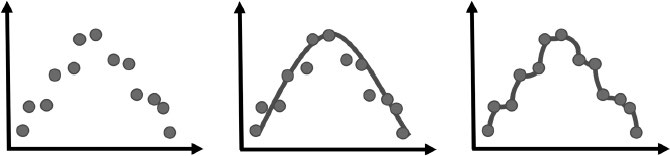

Es evidente que, en general, esta situación presenta un **impacto negativo** en la **eficiencia del modelo** cuando e**ste se usa para inferencia con datos nuevos**. 

Por ello, es muy importante evitar estar en esta situación; de aquí la **utilidad de reservar una parte de datos de entrenamiento como datos de validación** para poder detectar esta situación

**EARLY STOPPING**

* Uno de los motivos del sobreajuste es que **realizamos más epochs de las requeridas**. 
* Keras nos permite controlar que no nos excedamos de epochs de manera automática mediante ``callbacks`` 
* Consiste en añadir un **callback** **``EarlyStopping``** como **argumento en el método** ``fit()`` que, **automáticamente, para el entrenamiento cuando las métricas de la función de pérdida para los datos de validación no mejoran**
* Al **callback** ``EarlyStopping`` le indicamos con el argumento ``monitor`` qué métrica debe tener en cuenta y, con el argumento ``patience``, se le indica **cuántas epochs se deben considerar para verificar la mejora**

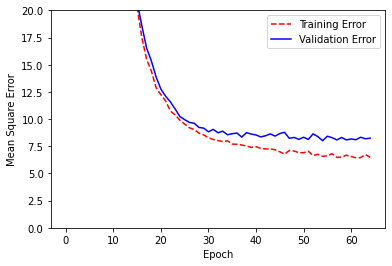

In [66]:
model = build_model()
model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(
      monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )

plot_history(history)


**EVALUACIÓN DEL MODELO CON LOS DATOS DE PRUEBA**

Finalmente, nos queda ver **lo bien que generaliza** el modelo al usar el **conjunto de datos de prueba**, que **no hemos usado en ningún momento durante el entrenamiento del modelo**. Esto será una indicación clara de **qué podemos esperar del modelo cuando lo usemos en el mundo real**. Para ello, usamos el método ``evaluate()``:

In [67]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 6ms/step - loss: 5.8654 - mae: 1.8702 - mse: 5.8654
Testing set Mean Abs Error:  5.87 MPG
Testing set Mean Sqr Error:  1.87 MPG


* En nuestro caso estamos interesados en el **error absoluto medio** (MAE), porque nos da un valor más «comprensible» para probar el modelo, es decir, directamente **indica la diferencia de millas por galón**. 
* Vemos que el modelo arroja un **error de unas 5 millas por galón** en el caso de **MAE**, que corresponde a unos **2.26 kilómetros por litro** de error. 
* Si lo pasamos al **error** que representa en **litros por 100 km** nos sale un error de unos 0,022 litros. (podemos considerar pequeño)=> Podemos concluir que el **MÉTODO GENERALIZA BIEN**.

**EVALUACIÓN DEL ENTRENAMIENTO CON MAE**

Hemos considerado la métrica **MAE para evaluar el error**, pero habíamos **usado** **MSE como función de pérdida**. 

Quizás tiene más sentido calcular los parámetros 
del modelo con la **función de pérdida MAE** en vez de la **MSE**. 

Podemos ver la gráfica de evolución del entrenamiento y observamos que también se adapta bien.

In [68]:
model = build_model()
model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae', 'mse'])

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0,
                    callbacks=[early_stop] )




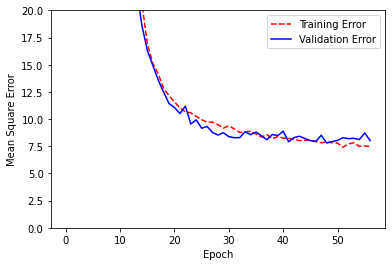

In [69]:
plot_history(history)

Al usar el conjunto de prueba para calcular el error con esta nueva función de pérdida, vemos que el modelo generaliza aproximadamente igual que el anterior, aportando unos resultados muy parecidos.

In [70]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels)
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))
print("Testing set Mean Sqr Error: {:5.2f} MPG".format(mse))

3/3 [==============================] - 0s 6ms/step - loss: 1.7450 - mae: 1.7450 - mse: 6.0482
Testing set Mean Abs Error:  6.05 MPG
Testing set Mean Sqr Error:  1.74 MPG


A partir de aquí, **deberíamos valorar si hace falta probar con otros modelos y otros hiperparámetros**. 

Pero, tal y como hemos valorado «subjetivamente», el **modelo arroja un error pequeño** (0.022 litros a los 100 km) y **podemos considerar que el método generaliza bien** y que es el **definitivo para usarlo para inferencia**. 

---